# **Install/Import required Python packages**
You'll need Python (3.7+) and the following packages:
* `pandas` (data structures)
* `lightgbm` (tree-based learning algorithms)
* `scikit-learn`
* `tqdm` (progress bar)

For this project, we will be using game log data from KaggleHub, specifically the [2022-23, 2023-24 and 2024-25](https://www.kaggle.com/datasets/eoinamoore/historical-nba-data-and-player-box-scores) NBA seasons, to build a dataset for fantasy basketball analysis.

In [1]:
pip install pandas lightgbm scikit-learn tqdm

In [2]:
import pandas as pd
import numpy as np
import kagglehub
import unicodedata
from tqdm import tqdm
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from concurrent.futures import ThreadPoolExecutor, as_completed

# **Fantasy Basketball Scoring**

We will use the default ESPN Fantasy Basketball scoring system as our target for prediction ([source](https://www.espn.com/fantasy/basketball/story/_/id/30296896/espn-fantasy-default-points-league-scoring-explained)):

* PTS = +1 (points scored)
* FG3M = +1 (3 pointers made)
* FGA = -1 (field goals attempted)
* FGM = +2 (field goals made)
* FTA = -1 (free throws attempted)
* FTM = +1 (free throws made)
* REB = +1 (rebounds)
* AST = +2 (assists)
* STL = +4 (steals)
* BLK = +4 (blocks)
* TOV = -2 (turnovers)

Additionally, we will gather player game logs from the last 3 NBA seasons to train the model and predict fantasy performance for the upcoming 2025–26 NBA season.

In [3]:
FANTASY_SCORING = {
    "PTS": 1,
    "FG3M": 1,
    "FGA": -1,
    "FGM": 2,
    "FTA": -1,
    "FTM": 1,
    "REB": 1,
    "AST": 2,
    "STL": 4,
    "BLK": 4,
    "TOV": -2
}

# **Helper Functions**

These functions are used to prepare and process the raw NBA data before training the model:

`compute_fantasy_points` – Calculates player's fantasy points for given game using the default ESPN Fantasy Basketball scoring system. These fantasy points serve as the target variable for the model.

`calculate_experience_curve` - Calculates an adjustment factor based on the number of seasons a player has been in the NBA. This feature models expected player growth and regression over the course of their career:

* **0–4 years**: Improvement phase (steep growth)
* **5–8 years**: Peak years (stable performance)
* **9–12 years**: Gradual regression
* **13+ years**: Late-career decline

In [4]:
def compute_fantasy_points(df):
    """
    Compute fantasy points for a player.
    """
    # Compute fantasy points
    fantasy_score = (
        df["points"] * FANTASY_SCORING["PTS"] +
        df["threePointersMade"] * FANTASY_SCORING["FG3M"] +
        df["fieldGoalsAttempted"] * FANTASY_SCORING["FGA"] +
        df["fieldGoalsMade"] * FANTASY_SCORING["FGM"] +
        df["freeThrowsAttempted"] * FANTASY_SCORING["FTA"] +
        df["freeThrowsMade"] * FANTASY_SCORING["FTM"] +
        df["reboundsTotal"] * FANTASY_SCORING["REB"] +
        df["assists"] * FANTASY_SCORING["AST"] +
        df["steals"] * FANTASY_SCORING["STL"] +
        df["blocks"] * FANTASY_SCORING["BLK"] +
        df["turnovers"] * FANTASY_SCORING["TOV"]
    )

    df["fantasyPoints"] = fantasy_score

    return df

def calculate_experience_curve(seasons):
    """
    Calculate experience curve for a player based on seasons played.
    """
    if seasons <= 4:
        return 1 + 0.05 * (4 - seasons)
    elif 5 <= seasons <= 8:
        return 1
    elif 9 <= seasons <= 12:
        return 1 - 0.02 * (seasons - 8)
    else:
        return 0.85 - 0.03 * (seasons - 12)

# **Build dataset for all active NBA players**

Let's prepare the dataset for all active NBA players that will be used to train our Gradient Boosting Decision Tree (GBDT) model.

As part of the data preparation, we will be using prepared Kaggle data that includes player game logs from NBA.com using `nba_api` and extract only the relevant features for modeling. Additionally, we will assign separate weights to each of the past 3 seasons, giving the more recent 2024-25 season greater influence on the model while still incorporating the previous seasons.

Start and end dates for the NBA seasons are taken from [Basketball Reference](https://www.basketball-reference.com/).

In [5]:
# Download the datasets
path = kagglehub.dataset_download("eoinamoore/historical-nba-data-and-player-box-scores")
path_players = kagglehub.dataset_download("yagizfiratt/nba-players-database")

csv = os.path.join(path, "PlayerStatistics.csv")
players_csv = os.path.join(path_players, "PlayerIndex_nba_stats.csv")

df = pd.read_csv(csv)
df["gameDate"] = pd.to_datetime(df["gameDate"])

df_players = pd.read_csv(players_csv)
df_players.rename(columns={"PERSON_ID": "personId", "POSITION": "position", "FROM_YEAR": "fromYear"}, inplace=True)

print(df_players.head())

# Define start and end dates for 2022-23 regular season
start_date_22_23 = pd.Timestamp("2022-10-18 00:00:00")
end_date_22_23 = pd.Timestamp("2023-04-09 23:59:59")

# Define start and end dates for 2023-24 regular season
start_date_23_24 = pd.Timestamp("2023-10-24 00:00:00")
end_date_23_24 = pd.Timestamp("2024-04-14 23:59:59")

# Define start and end dates for 2024-25 regular season
start_date_24_25 = pd.Timestamp("2024-10-22 00:00:00")
end_date_24_25 = pd.Timestamp("2025-04-13 23:59:59")

df_22_23 = df[(df["gameDate"] >= start_date_22_23) & (df["gameDate"] <= end_date_22_23)]
df_23_24 = df[(df["gameDate"] >= start_date_23_24) & (df["gameDate"] <= end_date_23_24)]
df_24_25 = df[(df["gameDate"] >= start_date_24_25) & (df["gameDate"] <= end_date_24_25)]

# Merge new position column with each seasons' dataframe based on personId
dataframes = [df_22_23, df_23_24, df_24_25]

for i, df_season in enumerate(dataframes):
    dataframes[i] = df_season.merge(
        df_players[["personId", "position", "fromYear"]],
        on="personId",
        how="left"
    )

# Unpack back into individual variables if needed
df_22_23, df_23_24, df_24_25 = dataframes

# Combine firstName and lastName into playerName
for df_season in [df_22_23, df_23_24, df_24_25]:
    df_season["playerName"] = df_season["firstName"] + " " + df_season["lastName"]

# Preview the data
print("2022-23 season sample:")
print(df_22_23.head())

print("\n2023-24 season sample:")
print(df_23_24.head())

print("\n2024-25 season sample:")
print(df_24_25.head())

Using Colab cache for faster access to the 'historical-nba-data-and-player-box-scores' dataset.
Using Colab cache for faster access to the 'nba-players-database' dataset.


/tmp/ipython-input-3340095438.py:8: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv)


   personId PLAYER_LAST_NAME PLAYER_FIRST_NAME          PLAYER_SLUG  \
0     76001        Abdelnaby              Alaa       alaa-abdelnaby   
1     76002       Abdul-Aziz              Zaid      zaid-abdul-aziz   
2     76003     Abdul-Jabbar            Kareem  kareem-abdul-jabbar   
3        51       Abdul-Rauf           Mahmoud   mahmoud-abdul-rauf   
4      1505      Abdul-Wahad             Tariq    tariq-abdul-wahad   

      TEAM_ID TEAM_SLUG  IS_DEFUNCT    TEAM_CITY      TEAM_NAME  \
0  1610612757   blazers           0     Portland  Trail Blazers   
1  1610612745   rockets           0      Houston        Rockets   
2  1610612747    lakers           0  Los Angeles         Lakers   
3  1610612743   nuggets           0       Denver        Nuggets   
4  1610612758     kings           0   Sacramento          Kings   

  TEAM_ABBREVIATION  ... DRAFT_YEAR DRAFT_ROUND DRAFT_NUMBER  ROSTER_STATUS  \
0               POR  ...     1990.0         1.0         25.0            NaN   
1           

In [6]:
# Define relevant columns to keep
cols_to_keep = [
    "personId", "playerName", "playerteamName", "position", "fromYear",
    "points", "threePointersMade", "fieldGoalsAttempted",
    "fieldGoalsMade", "freeThrowsAttempted", "freeThrowsMade",
    "reboundsTotal", "assists", "steals", "blocks", "turnovers"
]

# Ensure numeric columns
numeric_cols = ["points", "threePointersMade", "fieldGoalsAttempted",
    "fieldGoalsMade", "freeThrowsAttempted", "freeThrowsMade",
    "reboundsTotal", "assists", "steals", "blocks", "turnovers", "fromYear"]

df_22_23[numeric_cols] = df_22_23[numeric_cols].apply(pd.to_numeric, errors="coerce")
df_23_24[numeric_cols] = df_23_24[numeric_cols].apply(pd.to_numeric, errors="coerce")
df_24_25[numeric_cols] = df_24_25[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Keep only columns we want
df_22_23 = df_22_23[cols_to_keep]
df_22_23["seasonYear"] = "2022-23"

df_23_24 = df_23_24[cols_to_keep]
df_23_24["seasonYear"] = "2023-24"

df_24_25 = df_24_25[cols_to_keep]
df_24_25["seasonYear"] = "2024-25"

# Calculate seasons played and experience factor
df_22_23["seasonsPlayed"] = df_22_23["seasonYear"].str.split("-").str[0].astype(int) - df_22_23["fromYear"] + 1
df_22_23["experienceFactor"] = df_22_23["seasonsPlayed"].apply(calculate_experience_curve)

df_23_24["seasonsPlayed"] = df_23_24["seasonYear"].str.split("-").str[0].astype(int) - df_23_24["fromYear"] + 1
df_23_24["experienceFactor"] = df_23_24["seasonsPlayed"].apply(calculate_experience_curve)

df_24_25["seasonsPlayed"] = df_24_25["seasonYear"].str.split("-").str[0].astype(int) - df_24_25["fromYear"] + 1
df_24_25["experienceFactor"] = df_24_25["seasonsPlayed"].apply(calculate_experience_curve)

# Compute total and average Fantasy Points for each season separately
df_22_23 = compute_fantasy_points(df_22_23)
df_23_24 = compute_fantasy_points(df_23_24)
df_24_25 = compute_fantasy_points(df_24_25)

# Apply weights for each season
# 2024-25 season matters 3x more than 2022-23 season and 2x more than 2023-24 season
x = 0.2
y = 0.3
z = 0.6

scale = (x + y + z) / 3
x_scaled = x / scale
y_scaled = y / scale
z_scaled = z / scale

df_22_23['weightedFantasyPoints'] = df_22_23['fantasyPoints'] * x_scaled
df_23_24['weightedFantasyPoints'] = df_23_24['fantasyPoints'] * y_scaled
df_24_25['weightedFantasyPoints'] = df_24_25['fantasyPoints'] * z_scaled

# Combine the datasets
df = pd.concat([df_22_23, df_23_24, df_24_25], ignore_index=True)
df = df.sort_values(by="fantasyPoints", ascending=False).reset_index(drop=True)

print(df.head())
print("Dataset shape:", df.shape)

/tmp/ipython-input-2920231928.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_22_23["seasonYear"] = "2022-23"
/tmp/ipython-input-2920231928.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_23_24["seasonYear"] = "2023-24"
/tmp/ipython-input-2920231928.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

   personId     playerName playerteamName position  fromYear  points  \
0   1629029    Luka Doncic      Mavericks      F-G    2018.0    50.0   
1   1629029    Luka Doncic      Mavericks      F-G    2018.0    73.0   
2    203954    Joel Embiid          76ers      C-F    2014.0    59.0   
3   1629029    Luka Doncic      Mavericks      F-G    2018.0    60.0   
4    201939  Stephen Curry       Warriors        G    2009.0    52.0   

   threePointersMade  fieldGoalsAttempted  fieldGoalsMade  \
0                8.0                 25.0            15.0   
1                8.0                 33.0            25.0   
2                1.0                 28.0            19.0   
3                2.0                 31.0            21.0   
4               12.0                 31.0            16.0   

   freeThrowsAttempted  ...  reboundsTotal  assists  steals  blocks  \
0                 12.0  ...            6.0     15.0     4.0     3.0   
1                 16.0  ...           10.0      7.0     1.

In [7]:
# Compute average fantasy points for player over season
season_avg = (
    df.groupby(["personId", "playerName", "seasonYear"])["fantasyPoints"]
    .mean()
    .reset_index()
    .rename(columns={"fantasyPoints": "fantasyPointsCurrSeason"})
)

# Sort to prepare for shift
season_avg = season_avg.sort_values(["personId", "seasonYear"])

# Get prior season’s fantasy points and change in points
season_avg["fantasyPointsPrevSeason"] = season_avg.groupby("personId")["fantasyPointsCurrSeason"].shift(1)
season_avg["fantasyPointsChange"] = season_avg["fantasyPointsCurrSeason"] - season_avg["fantasyPointsPrevSeason"]

# Merge back into main df
df = df.merge(
    season_avg,
    on=["personId", "playerName", "seasonYear"],
    how="left"
)

print(df[["playerName", "seasonYear", "fantasyPointsPrevSeason", "fantasyPointsCurrSeason", "fantasyPointsChange"]].head())
print("Dataset shape:", df.shape)


      playerName seasonYear  fantasyPointsPrevSeason  fantasyPointsCurrSeason  \
0    Luka Doncic    2023-24                57.272727                64.042857   
1    Luka Doncic    2023-24                57.272727                64.042857   
2    Joel Embiid    2022-23                      NaN                54.275362   
3    Luka Doncic    2022-23                      NaN                57.272727   
4  Stephen Curry    2024-25                42.418919                42.068493   

   fantasyPointsChange  
0             6.770130  
1             6.770130  
2                  NaN  
3                  NaN  
4            -0.350426  
Dataset shape: (96474, 24)


# **Train Gradient Boosting Model**

A LightGBM regression model is trained to predict fantasy points per game using the dataset of NBA player stats we just built. LightGBM is a type of Gradient Boosting Decision Tree (GBDT) that works particularly well for structured tabular data like box scores.

* `"learning_rate": 0.01` controls the step size at which the model updates its weights during the boosting process. Smaller values means model learns slower.

* `"num_leaves": 127` controls the maximum leaves per tree. Higher number means more complex patterns get captured by model.

* `"feature_fraction": 0.8` means that 80% of features are randomly used for each split.

* `"bagging_fraction": 0.8` means that 80% of the data will be used for training in each bagging iteration.

* `"min_data_in_leaf": 20` sets the minimum number of samples required in one leaf.

* `"bagging_freq": 5` determines the frequency that model performs bagging. Bagging is the combining of multiple independent models trained on different random subsets of the original data.

* `num_boost_round=3000` sets the maximum number of boosting iterations (trees) to learn complex patterns in the data.

* `early_stopping(stopping_rounds=100)` ensures training stops if the validation error does not improve for 100 consecutive iterations, helping prevent overfitting.

* `log_evaluation(period=200)` prints progress every 200 iterations so we can monitor the model’s performance.

After training, we evaluate the model using Root Mean Squared Error (RMSE), which measures how far the predicted fantasy points deviate from the actual values. A lower RMSE indicates better predictive accuracy.

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 7.62283
[400]	valid_0's rmse: 5.02667
[600]	valid_0's rmse: 3.85757
[800]	valid_0's rmse: 3.18006
[1000]	valid_0's rmse: 2.75977
[1200]	valid_0's rmse: 2.51209
[1400]	valid_0's rmse: 2.33335
[1600]	valid_0's rmse: 2.22949
[1800]	valid_0's rmse: 2.14604
[2000]	valid_0's rmse: 2.09105
[2200]	valid_0's rmse: 2.05456
[2400]	valid_0's rmse: 2.02014
[2600]	valid_0's rmse: 1.9926
[2800]	valid_0's rmse: 1.96974
[3000]	valid_0's rmse: 1.94974
Did not meet early stopping. Best iteration is:
[3000]	valid_0's rmse: 1.94974
RMSE: 1.9497446871968545


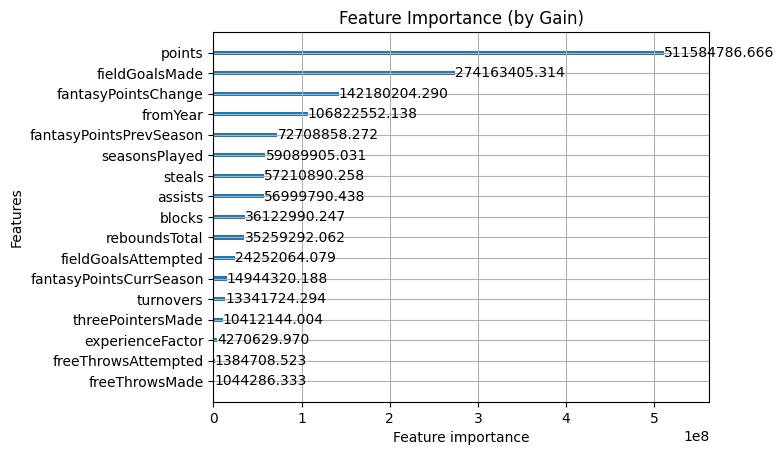

In [8]:
features = numeric_cols + [
    "fantasyPointsCurrSeason",
    "fantasyPointsPrevSeason",
    "fantasyPointsChange",
    "seasonsPlayed",
    "experienceFactor"
]

# Create feature matrix and target
X = df[features]
y = df["weightedFantasyPoints"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# lgb refers to LightGBM, a popular gradient boosting framework from Microsoft
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.01,
    "num_leaves": 127,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_data_in_leaf": 20,
    "verbose": -1
}

# Use a callback for early stopping
callbacks = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=200)
]

# Train the model
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=3000,
    callbacks=callbacks
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate accuracy of model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

lgb.plot_importance(model, importance_type='gain')
plt.title("Feature Importance (by Gain)")
plt.show()

# **Get Player Rankings**

This step produces the final rankings that can be used for fantasy basketball drafts or lineup decisions, taking into account player performance trends, positional roles, and season weights.

In [9]:
df["predictedFantasyPoints"] = model.predict(df[features])
player_ranks = df.groupby(["playerName"]).agg(
    predictedFantasyPoints=("predictedFantasyPoints", "mean"),
    fantasyPoints=("fantasyPoints", "mean"),
    playerteamName=("playerteamName", "last"),
    position=("position", "last")
).reset_index()

players = player_ranks.sort_values(by="predictedFantasyPoints", ascending=False).reset_index(drop=True)

# Separate by position
guards = player_ranks[player_ranks["position"] == "G"].sort_values(by="predictedFantasyPoints", ascending=False).reset_index(drop=True)
guards_forwards = player_ranks[player_ranks["position"].isin(["G-F", "F-G"])].sort_values(by="predictedFantasyPoints", ascending=False).reset_index(drop=True)
forwards = player_ranks[player_ranks["position"] == "F"].sort_values(by="predictedFantasyPoints", ascending=False).reset_index(drop=True)
fowards_centers = player_ranks[player_ranks["position"].isin(["F-C", "C-F"])].sort_values(by="predictedFantasyPoints", ascending=False).reset_index(drop=True)
centers = player_ranks[player_ranks["position"] == "C"].sort_values(by="predictedFantasyPoints", ascending=False).reset_index(drop=True)

In [10]:
print("Top Players:")
print(players.head(50)[["playerName", "playerteamName", "predictedFantasyPoints"]])

print("\nTop Guards:")
print(guards.head(25)[["playerName", "playerteamName", "predictedFantasyPoints"]])

print("\nTop Guards/Forwards:")
print(guards_forwards.head(25)[["playerName", "playerteamName", "predictedFantasyPoints"]])

print("\nTop Forwards:")
print(forwards.head(25)[["playerName", "playerteamName", "predictedFantasyPoints"]])

print("\nTop Forwards/Centers:")
print(fowards_centers.head(25)[["playerName", "playerteamName", "predictedFantasyPoints"]])

print("\nTop Centers:")
print(centers.head(25)[["playerName", "playerteamName", "predictedFantasyPoints"]])

Top Players:
                 playerName playerteamName  predictedFantasyPoints
0              Nikola Jokic        Nuggets               65.200932
1         Victor Wembanyama          Spurs               60.642943
2   Shai Gilgeous-Alexander        Thunder               57.159941
3     Giannis Antetokounmpo          Bucks               56.643064
4               Luka Doncic      Mavericks               53.932708
5              LeBron James         Lakers               50.567114
6         Tyrese Haliburton         Pacers               49.678094
7             Anthony Davis      Mavericks               48.992446
8           Cade Cunningham        Pistons               48.688172
9              Kevin Durant           Suns               47.694380
10       Karl-Anthony Towns         Knicks               47.506876
11             Jayson Tatum        Celtics               46.487409
12              LaMelo Ball        Hornets               46.436146
13             James Harden       Clippers       

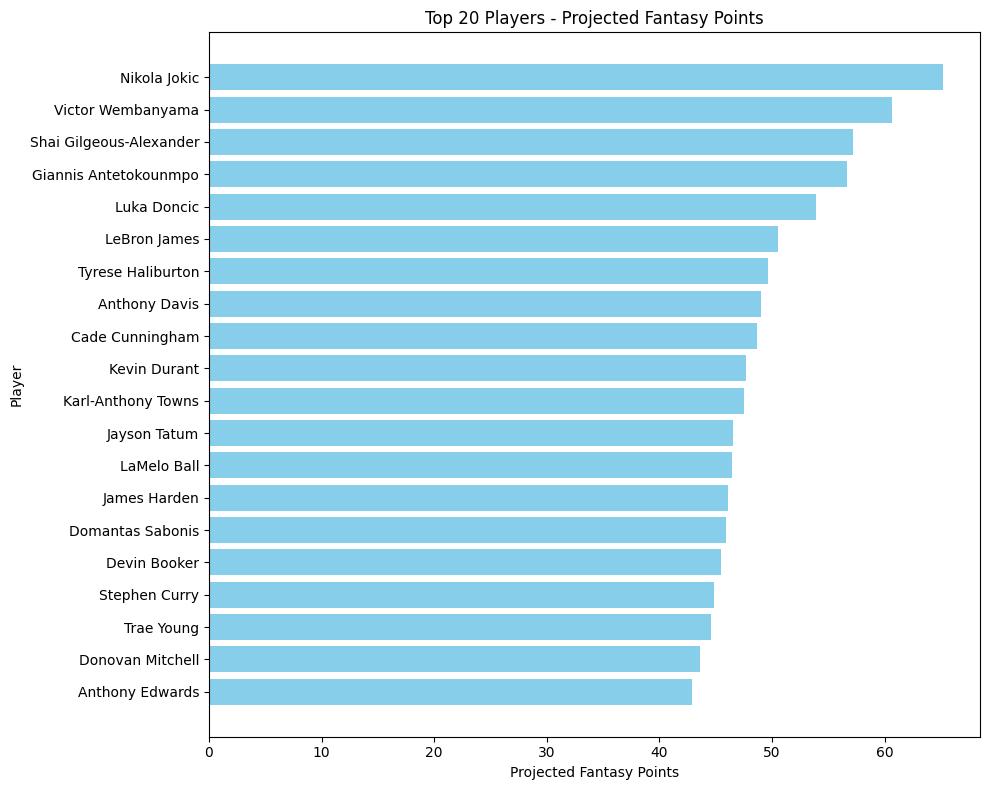

In [11]:
# Sort players by predicted fantasy points
players_sorted = player_ranks.sort_values(by='predictedFantasyPoints', ascending=True)

# Select top N players for bar chart
top_n = 20
players_top = players_sorted.tail(top_n)

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(players_top['playerName'], players_top['predictedFantasyPoints'], color='skyblue')
plt.xlabel('Projected Fantasy Points')
plt.ylabel('Player')
plt.title(f'Top {top_n} Players - Projected Fantasy Points')
plt.tight_layout()
plt.show()